In [1]:
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

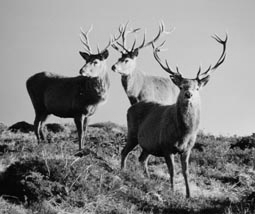

In [15]:
PIL.Image.open('./HoofedAnimals/org/90.pgm')

In [3]:
640*480

307200

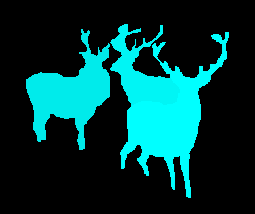

In [4]:
PIL.Image.open('./HoofedAnimals/seg/masks/90_mask.ppm')

In [5]:
L = np.asarray([[*PIL.Image.open(f'./HoofedAnimals/org/{i}.pgm').size, i] for i in range(1, 201)])

In [6]:
unusable = [PIL.Image.open(f'./HoofedAnimals/org/{i}.pgm').size != PIL.Image.open(f'./HoofedAnimals/seg/masks/{i}_mask.ppm').size for i in range(1, 201) ]

In [7]:
sum(unusable)

3

Certains masques n'ont pas la même taille que l'image d'origine. Par simplicité on va les éliminer de la base de données

## Preprocessing   
Les images sont de tailles variables:   
- padding : on complete avec des 0 pour avoir des images de meme taille

In [8]:
df = pd.DataFrame({'Width': L[:, 0], 'Height': L[:, 1], 'Area': L[:, 0] * L[:, 1], 'number': L[:, 2], 'unusable': unusable} )
df.drop(df.loc[df.unusable].index, inplace=True)
biggest = np.array(df[['Width', 'Height']].max())
print(f"The biggest image has shape {biggest}")
df

The biggest image has shape [1353  910]


,Width,Height,Area,number,unusable
0,300,225,67500,1,False
1,300,225,67500,2,False
2,300,225,67500,3,False
3,300,225,67500,4,False
4,263,133,34979,5,False
...,...,...,...,...,...
195,448,336,150528,196,False
196,480,360,172800,197,False
197,425,293,124525,198,False
198,500,402,201000,199,False


The biggest image has shape [1353  910]


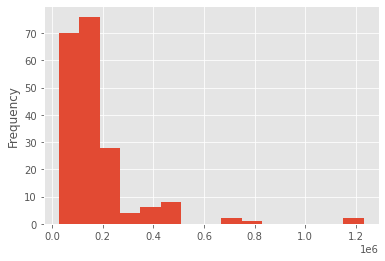

In [9]:
plt.style.use('ggplot')
df['Area'].plot.hist(bins=15)
print(f"The biggest image has shape {biggest}")

Les images les plus grandes sont des outliers. Il serait couteux en memoire d'aggrandir toutes les images à leur taille. On limite la taille des images à 300 000 pixels

(174, 5)
All image have at most shape [447 654]


,Width,Height,Area,number,unusable
163,300,229,68700,164,False
166,500,333,166500,167,False
167,300,234,70200,168,False
168,300,216,64800,169,False
169,600,340,204000,170,False
173,568,426,241968,174,False
174,377,256,96512,175,False
175,572,447,255684,176,False
176,591,386,228126,177,False
180,428,270,115560,181,False


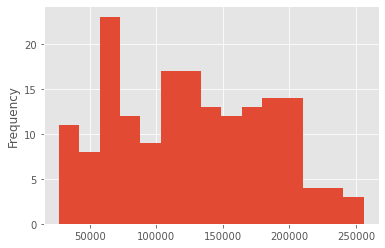

In [10]:
df.drop(df.loc[df.Area>=300000].index, inplace=True)
print(df.shape)
df.Area.plot.hist(bins=15)
biggest = np.array(df[['Height', 'Width']].max())
print(f"All image have at most shape {biggest}")

df.tail(20)

In [11]:
retained_id = (df.number).to_list() 
len(retained_id)

174

In [12]:
import torch
import torch.nn as nn

In [13]:
df.sort_index(inplace=True)
imgs, target_masks = [], []

for i in tqdm(retained_id):
    img = np.asarray(PIL.Image.open(f'./HoofedAnimals/org/{i}.pgm'))
    mask = np.asarray(PIL.Image.open(f'./HoofedAnimals/seg/masks/{i}_mask.ppm'))
    size = np.array(img.shape)
    correction = (biggest - size).astype(int)
    pad = [correction[1] // 2, correction[1] - correction[1] // 2, correction[0] // 2, correction[0] - correction[0] // 2]
    img = torch.tensor(img)
    mask = torch.tensor(mask)
    
    img = nn.functional.pad(input=img, pad=pad)
    mask = nn.functional.pad(input=mask, pad=[0, 0, *pad]) #la fonction pad s'applique en premier aux dernière dimensions, ie la couleur pour mask, ce qui n'est pas souhaitable
    imgs.append(img.detach().numpy())
    target_masks.append(mask.detach().numpy())

  0%|          | 0/174 [00:00<?, ?it/s]

In [14]:
images = torch.tensor(imgs)
target_masks = torch.tensor(target_masks)